## Project: food price forecasting using LSTM neural networks

**Team Members:** Martin Coleman, Atul Venkatesh, Jennifer Lee, Shayan Yasir

**Date:** November 20, 2025

## Project Overview

In this project, we implement a Long Short-Term Memory (LSTM) recurrent neural network to forecast next-month prices for rice, maize, and wheat using the Global Food Prices dataset from Kaggle. The dataset contains approximately 3 million monthly observations across ~99 countries from 2000 to present. We compare the LSTM against two baseline models: a naïve "last-value" predictor and a tuned ARIMA model. Performance is evaluated using Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Directional Accuracy. The project includes exploratory data analysis, feature engineering, model training, and feature importance analysis to understand which temporal patterns the model learns.


In [1]:
#installing required packages
%pip install seaborn statsmodels tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 21.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Note: SHAP not available, will use permutation importance instead")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Note: SHAP not available, will use permutation importance instead
TensorFlow version: 2.20.0
Pandas version: 2.3.3
NumPy version: 2.2.6


## 2. Data Loading & Cleaning


In [3]:
#extracting and loading the dataset
import zipfile
import os

#try-except block for extracting zip 
try:
    zip_path = 'kaggle-dataset-globalfoodprices.zip'  #update this to your actual path
    extract_dir = './temp_extract'
    #extracting if not already done
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
except FileNotFoundError as e:
    print(f"Error: {e}")
    #if zip extraction fails, try loading CSV directly
    csv_path = 'Global WFP Food Prices.csv' 
    extract_dir = None

#finding CSV in extracted directory
if extract_dir and os.path.exists(extract_dir):
    csv_files = [f for f in os.listdir(extract_dir) if f.endswith('.csv')]
    print(f"Found CSV files: {csv_files}")
    csv_path = os.path.join(extract_dir, csv_files[0])
else:
    #if CSV is already extracted, use it directly
    if not os.path.exists(csv_path):
        csv_path = 'Global WFP Food Prices.csv'  #try current directory
    print(f"Loading CSV directly: {csv_path}")

#load dataset + reading in chunks for large files to avoid memory issues
print(f"Loading: {csv_path}")
chunk_list = []
chunk_size = 100000
for chunk in pd.read_csv(csv_path, chunksize=chunk_size, low_memory=False):
    chunk_list.append(chunk)

#dataframe holding all chunks 
df_raw = pd.concat(chunk_list, ignore_index=True)
#printing summary of data
print(f"loaded {len(df_raw):,} rows")
print(f"cols: {list(df_raw.columns)}")


Found CSV files: ['Global WFP Food Prices.csv']
Loading: ./temp_extract/Global WFP Food Prices.csv
loaded 3,109,617 rows
cols: ['country_code', 'date', 'county', 'subcounty', 'market', 'market_id', 'latitude', 'longitude', 'category', 'commodity', 'commodity_id', 'unit', 'price_flag', 'price_type', 'currency', 'local_price', 'price_usd']


In [4]:
#Checking state of accumulated data
print("\nPrinting first few rows of data to check:")
print(df_raw.head())

print("\nPrinting data types per column:")
print(df_raw.dtypes)

print("\nPrinting any missing values per column:")
print(df_raw.isnull().sum())



Printing first few rows of data to check:
  country_code        date      county       subcounty    market  market_id  \
0          AFG  2000-01-15  Badakhshan       Faiz Abad  Fayzabad        266   
1          AFG  2000-01-15       Balkh  Mazar-e-Sharif     Mazar        267   
2          AFG  2000-01-15       Hirat           Hirat     Hirat        270   
3          AFG  2000-01-15       Hirat           Hirat     Hirat        270   
4          AFG  2000-01-15       Hirat           Hirat     Hirat        270   

   latitude  longitude            category  \
0     37.12      70.58            non-food   
1     36.73      67.11            non-food   
2     34.35      62.20  cereals and tubers   
3     34.35      62.20  cereals and tubers   
4     34.35      62.20  cereals and tubers   

                                       commodity  commodity_id unit  \
0  Wage (non-qualified labour, non-agricultural)           465  Day   
1  Wage (non-qualified labour, non-agricultural)           465 

#why we chose rice, maize, and wheat:
We picked these three because they're major staple foods globally (found this on Wikipedia: https://en.wikipedia.org/wiki/Staple_food). They're widely traded and have big economic impact, so we thought analyzing their prices would be interesting and relevant.

In [5]:
#changing the date col to datetime format
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

#printing most unique top 50 commodities
print("\nUnique commodities (first 50):")
print(df_raw['commodity'].unique()[:50])

#catching all varieties of rice, maize, and wheat 
rice_matches = df_raw[df_raw['commodity'].str.contains('rice', case=False, na=False)]['commodity'].unique()
maize_matches = df_raw[df_raw['commodity'].str.contains('maize|corn', case=False, na=False)]['commodity'].unique()
wheat_matches = df_raw[df_raw['commodity'].str.contains('wheat', case=False, na=False)]['commodity'].unique()

#printing all matches for varieties of rice, maize, wheat
print("\nRice matches:", rice_matches)
print("Maize matches:", maize_matches)
print("Wheat matches:", wheat_matches)



Unique commodities (first 50):
['Wage (non-qualified labour, non-agricultural)' 'Bread' 'Wheat'
 'Wheat flour' 'Fuel (diesel)'
 'Livestock (sheep, one-year-old alive female)' 'Fuel (petrol-gasoline)'
 'Millet' 'Rice (coarse, BR-8/ 11/, Guti Sharna)' 'Maize (white)'
 'Rice (high quality)' 'Rice (ordinary, second quality)' 'Sugar (white)'
 'Maize (yellow)' 'Teff' 'Sorghum (white)' 'Rice (medium quality)'
 'Rice (ordinary, first quality)' 'Sorghum' 'Jalapeño pepper (big size)'
 'Lemons (Criollo, medium size)' 'Beans (black)' 'Beans (white)'
 'Bananas (medium size)' 'Broccoli' 'Cabbage' 'Carrots'
 'Cauliflower (medium size)' 'Cucumbers' 'Garlic (medium)'
 'Lemons (Persa, medium size)' 'Lettuce' 'Melons (cantaloupe)'
 'Oranges (Valencia, medium size)' 'Pineapples' 'Plantains (big size)'
 'Plantains (medium size)' 'Strawberries' 'Tomatoes (big size)'
 'Watermelons' 'Beans (red)' 'Potatoes' 'Peach (medium size)' 'Rice'
 'Oil (mustard)' 'Sugar' 'Onions' 'Chickpeas' 'Rice (long grain, Sinaloa)

In [6]:
#filtering dataset we made earlier for rice, maize, and wheat 
df_filtered = df_raw[
    (df_raw['commodity'].str.contains('Rice', case=False, na=False)) |
    (df_raw['commodity'].str.contains('Maize|Corn', case=False, na=False)) |
    (df_raw['commodity'].str.contains('Wheat', case=False, na=False))
].copy()

print(f"Rows after filtering to rice/maize/wheat: {len(df_filtered):,}")

#standardizing name func for our 3 commodities
def standardize_commodity(name):
    name_lower = str(name).lower() #changing to lowercase for easier matching
    if 'rice' in name_lower:
        return 'Rice'
    elif 'maize' in name_lower or 'corn' in name_lower:
        return 'Maize'
    elif 'wheat' in name_lower:
        return 'Wheat'
    return name #simply returning original name if no matches found

#applying standardization function
df_filtered['commodity'] = df_filtered['commodity'].apply(standardize_commodity)
print("\nCommodity counts post-standardization:")
print(df_filtered['commodity'].value_counts())


Rows after filtering to rice/maize/wheat: 662,115

Commodity counts post-standardization:
commodity
Rice     337795
Maize    201088
Wheat    123232
Name: count, dtype: int64


In [7]:
#we're using USD prices for consistency across countries, so we are culling any rows without valid USD prices
df_filtered = df_filtered[df_filtered['price_usd'].notna()].copy() #removing rows without USD prices
df_filtered = df_filtered[df_filtered['price_usd'] > 0].copy() #removing rows with USD that's 0 or -

#standardizing units of measurement to just rows with 'KG'
df_filtered = df_filtered[df_filtered['unit'].str.upper() == 'KG'].copy()

print(f"Rows after filtering to valid USD prices and KG unit: {len(df_filtered):,}")
print(f"\nDate range: {df_filtered['date'].min()} to {df_filtered['date'].max()}")
print(f"\nCountries: {df_filtered['country_code'].nunique()}")
print(f"\nCountries with most data:")
print(df_filtered['country_code'].value_counts().head(10))


Rows after filtering to valid USD prices and KG unit: 564,047

Date range: 2000-01-15 00:00:00 to 2025-09-15 00:00:00

Countries: 87

Countries with most data:
country_code
MLI    39201
IDN    32284
BDI    26169
NER    23625
IND    22239
MWI    21660
MOZ    20581
ZMB    19863
RWA    19636
SEN    18332
Name: count, dtype: int64


In [8]:
#choosing a country with good coverage for all three commodities
country_stats = []
for country in df_filtered['country_code'].unique():
    country_data = df_filtered[df_filtered['country_code'] == country]
    #get the country's unique commodities + check if it has the 3 required commodities
    commodities = country_data['commodity'].unique()
    date_range = (country_data['date'].max() - country_data['date'].min()).days

    has_all = all(c in commodities for c in ['Rice', 'Maize', 'Wheat'])

    #only storing country's stats if it has all 3 commodities
    if has_all:
        country_stats.append({
            'country': country,
            'date_range_days': date_range,
            'num_obs': len(country_data),
            'start_date': country_data['date'].min(),
            'end_date': country_data['date'].max()
        })

#creating df to hold country stats
country_df = pd.DataFrame(country_stats).sort_values('num_obs', ascending=False)
print("\nTop 10 countries with all three commodities:")
print(country_df.head(10))

#choosing the country the most data
selected_country = country_df.iloc[0]['country']
print(f"\nSelected country: {selected_country}")

#filter dataset for just the chosen country
df_country = df_filtered[df_filtered['country_code'] == selected_country].copy()
print(f"\nData for {selected_country}: {len(df_country):,} rows")
print(f"Date range: {df_country['date'].min()} to {df_country['date'].max()}")
print(f"\nCommodity counts:")
print(df_country['commodity'].value_counts())



Top 10 countries with all three commodities:
   country  date_range_days  num_obs start_date   end_date
9      MLI             8156    39201 2003-01-15 2025-05-15
2      NER             9344    23625 2000-01-15 2025-08-15
1      MOZ             8826    20581 2000-01-15 2024-03-15
4      RWA             9315    19636 2000-03-15 2025-09-15
6      BEN             8370    14399 2002-01-15 2024-12-15
29     SYR             5205    13816 2011-04-15 2025-07-15
20     COD             6697    12779 2007-03-15 2025-07-15
17     KGZ             7517    11322 2005-01-15 2025-08-15
21     GNB             6575     8968 2007-06-15 2025-06-15
0      COL             9071     7175 2000-01-15 2024-11-15

Selected country: MLI

Data for MLI: 39,201 rows
Date range: 2003-01-15 00:00:00 to 2025-05-15 00:00:00

Commodity counts:
commodity
Rice     26727
Maize    10603
Wheat     1871
Name: count, dtype: int64


In [9]:
#creating monthly aggregated time series
df_country['year_month'] = df_country['date'].dt.to_period('M')

#aggregating by month and commodity
monthly_prices = df_country.groupby(['year_month', 'commodity'])['price_usd'].mean().reset_index()

#pivot to get separate columns for each commodity
df_ts = monthly_prices.pivot(index='year_month', columns='commodity', values='price_usd')
df_ts.index = df_ts.index.to_timestamp()
df_ts = df_ts.sort_index()

#renaming columns for consistency
df_ts.columns = [f"{col.lower()}_price" for col in df_ts.columns]

print(f"\nFinal time series shape: {df_ts.shape}")
print(f"Date range: {df_ts.index.min()} to {df_ts.index.max()}")
print(f"\nMissing values per commodity:")
print(df_ts.isnull().sum())

#forward fill missing months 
missing_before = df_ts.isnull().sum().sum()
df_ts = df_ts.ffill(limit=3)  #forward fill up to 3 months
df_ts = df_ts.bfill(limit=3)  #backward fill up to 3 months
missing_after = df_ts.isnull().sum().sum()

print(f"\nMissing values filled: {missing_before - missing_after}")

#drop any remaining rows with missing values
df_ts = df_ts.dropna()

print(f"\nFinal time series after cleaning: {len(df_ts)} months")
print(f"\nFinal columns: {list(df_ts.columns)}")
print("\nFirst few rows:")
print(df_ts.head())
print("\nLast few rows:")
print(df_ts.tail())



Final time series shape: (269, 3)
Date range: 2003-01-01 00:00:00 to 2025-05-01 00:00:00

Missing values per commodity:
maize_price      1
rice_price       0
wheat_price    214
dtype: int64

Missing values filled: 11

Final time series after cleaning: 65 months

Final columns: ['maize_price', 'rice_price', 'wheat_price']

First few rows:
            maize_price  rice_price  wheat_price
year_month                                      
2020-01-01     0.267500    0.623966     0.683056
2020-02-01     0.267833    0.608232     0.683056
2020-03-01     0.287797    0.636358     0.683056
2020-04-01     0.286066    0.603187     0.683056
2020-05-01     0.285932    0.588212     3.666250

Last few rows:
            maize_price  rice_price  wheat_price
year_month                                      
2025-01-01     0.414677    0.852887     0.949091
2025-02-01     0.415965    0.822320     0.757000
2025-03-01     0.425789    0.896308     0.961053
2025-04-01     0.478065    0.937160     0.944063
2025-0

### Data Description

After filtering and cleaning, we ended up with 65 months of monthly aggregated prices for rice, maize, and wheat from Mali (MLI). The time period spans from January 2020 to May 2025. We chose Mali because it had the most complete data coverage for all three commodities compared to other countries in the dataset.

All prices are standardized to USD per kilogram. We had to forward-fill and backward-fill some missing values (up to 3 months) to create a continuous time series, and dropped any remaining rows with gaps. This left us with 65 months of clean data, though after creating sequences for the LSTM we ended up with fewer usable samples.


## 3. Exploratory Data Analysis (EDA)


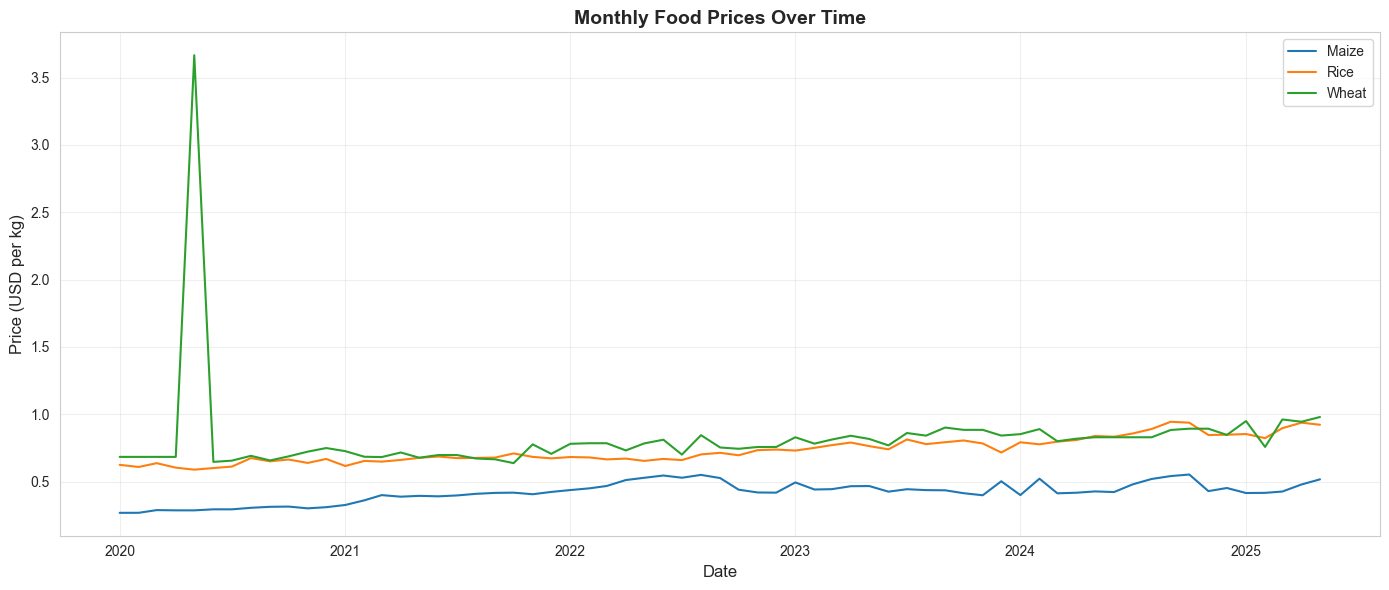

In [10]:
#time series plot for all three commodities
plt.figure(figsize=(14, 6))
for col in df_ts.columns:
    plt.plot(df_ts.index, df_ts[col], label=col.replace('_price', '').title(), linewidth=1.5)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per kg)', fontsize=12)
plt.title('Monthly Food Prices Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


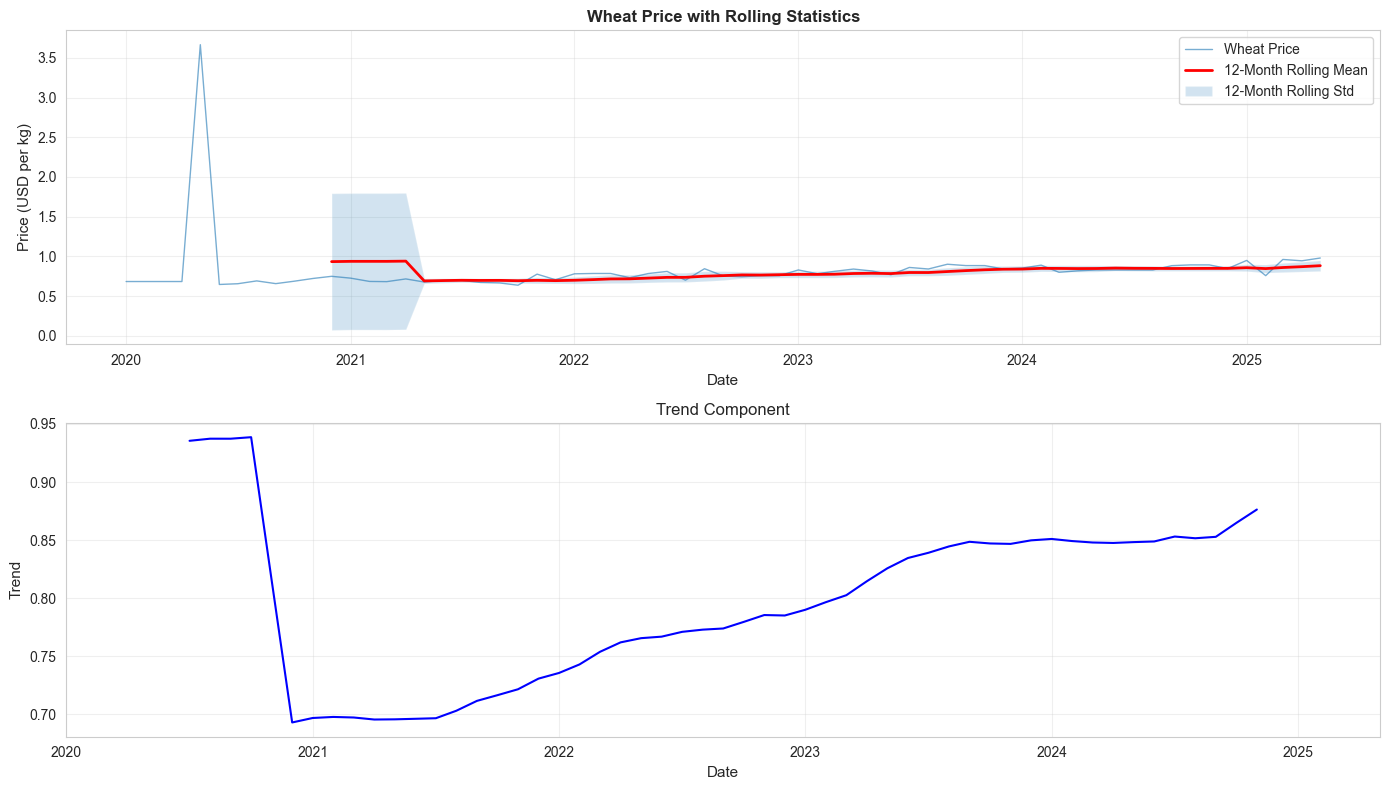

In [11]:
#takin rolling stats because averaging over the last 12 months removes short-term spikes and shows the actual price trend
window = 12  

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

#rolling mean and std for wheat
wheat_col = 'wheat_price'
if wheat_col in df_ts.columns:
    rolling_mean = df_ts[wheat_col].rolling(window=window).mean()
    rolling_std = df_ts[wheat_col].rolling(window=window).std()

    axes[0].plot(df_ts.index, df_ts[wheat_col], label='Wheat Price', alpha=0.6, linewidth=1)
    axes[0].plot(df_ts.index, rolling_mean, label=f'{window}-Month Rolling Mean', linewidth=2, color='red')
    axes[0].fill_between(df_ts.index,
                         rolling_mean - rolling_std,
                         rolling_mean + rolling_std,
                         alpha=0.2, label=f'{window}-Month Rolling Std')
    axes[0].set_xlabel('Date', fontsize=11)
    axes[0].set_ylabel('Price (USD per kg)', fontsize=11)
    axes[0].set_title('Wheat Price with Rolling Statistics', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

#the data for food commodities does fluctuate based on season so we're
#breaking the series into seasonal parts so we can see the underlying pattern more clearly
if len(df_ts) >= 24:  #roughly 2 years of data
    decomposition = seasonal_decompose(df_ts[wheat_col], model='additive', period=12)

    decomposition.trend.plot(ax=axes[1], title='Trend Component', color='blue', linewidth=1.5)
    axes[1].set_xlabel('Date', fontsize=11)
    axes[1].set_ylabel('Trend', fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


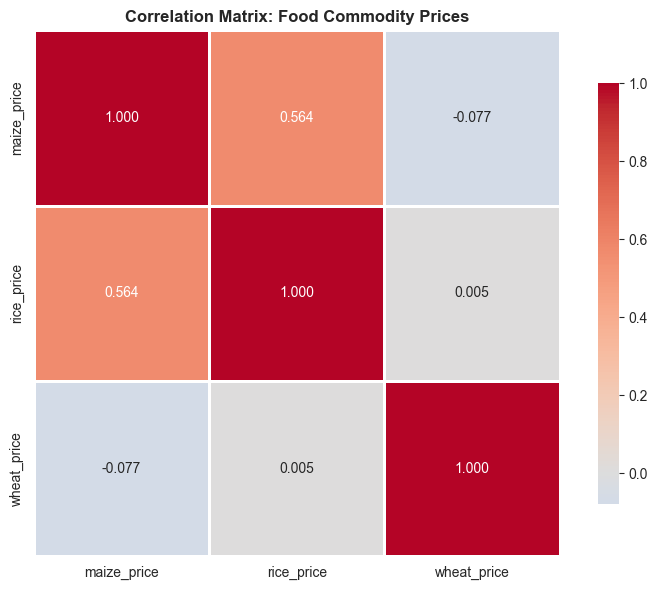


Correlation values:
             maize_price  rice_price  wheat_price
maize_price     1.000000    0.564340    -0.077423
rice_price      0.564340    1.000000     0.004643
wheat_price    -0.077423    0.004643     1.000000


In [12]:
#correlation analysis
correlation_matrix = df_ts.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Food Commodity Prices', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation values:")
print(correlation_matrix)


### EDA Notes

Looking at the plots:
- Prices have trends over time (some go up, some go down)
- There's volatility - some periods are stable, others have spikes
- Might be some seasonal patterns (harvest cycles?)
- The commodities are somewhat correlated - they tend to move together

This suggests LSTMs could work well since they can learn both short-term and longer-term patterns.


## 4. Problem Formulation & Objective

Our goal is to forecast next-month prices for rice, maize, and wheat using historical price data. We use past monthly prices along with calendar features (month, year) as inputs, and predict the price for each commodity in the next month.

We compare our LSTM model against two baselines: a naïve model that simply predicts next month equals the current month, and an ARIMA model. For evaluation, we use an 80/20 chronological train/test split (not random, since this is time series data) and measure performance using RMSE, MAPE, and directional accuracy.


## 5. Feature Engineering


In [ ]:
#create calendar features
df_features = df_ts.copy()

#month (1-12)
df_features['month'] = df_features.index.month

#year
df_features['year'] = df_features.index.year

#cyclical encoding for month (sine/cosine) - helps model understand seasonality
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

#create lag features - these are probably the most important
for lag in [1, 3, 6, 12]:
    for col in ['rice_price', 'maize_price', 'wheat_price']:
        if col in df_features.columns:
            df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag)

#price changes - tried adding more but these seemed to work best
for col in ['rice_price', 'maize_price', 'wheat_price']:
    if col in df_features.columns:
        df_features[f'{col}_change'] = df_features[col].diff()
        df_features[f'{col}_pct_change'] = df_features[col].pct_change()

#rolling stats - using 6 and 12 month windows (tried 3 but 6 and 12 seemed to work better)
for window in [6, 12]:
    for col in ['rice_price', 'maize_price', 'wheat_price']:
        if col in df_features.columns:
            df_features[f'{col}_rolling_mean_{window}'] = df_features[col].rolling(window=window).mean()
            df_features[f'{col}_rolling_std_{window}'] = df_features[col].rolling(window=window).std()

#cross-commodity ratios - thought these might help capture relationships
if 'rice_price' in df_features.columns and 'maize_price' in df_features.columns:
    df_features['rice_maize_ratio'] = df_features['rice_price'] / (df_features['maize_price'] + 1e-8)

#TODO: maybe try adding more features later? but dataset is small so probably not worth it
#tried adding momentum indicators but didn't help much

print("Feature columns:")
print(df_features.columns.tolist())
print(f"\nShape: {df_features.shape}")
print(f"\nNumber of features: {len(df_features.columns)}")
print("\nFirst few rows (after features stabilize):")
print(df_features.iloc[15:20])

Feature columns:
['maize_price', 'rice_price', 'wheat_price', 'month', 'year', 'month_sin', 'month_cos', 'rice_price_lag1', 'maize_price_lag1', 'wheat_price_lag1', 'rice_price_lag3', 'maize_price_lag3', 'wheat_price_lag3', 'rice_price_lag6', 'maize_price_lag6', 'wheat_price_lag6', 'rice_price_lag12', 'maize_price_lag12', 'wheat_price_lag12', 'rice_price_change', 'rice_price_pct_change', 'maize_price_change', 'maize_price_pct_change', 'wheat_price_change', 'wheat_price_pct_change', 'rice_price_rolling_mean_6', 'rice_price_rolling_std_6', 'maize_price_rolling_mean_6', 'maize_price_rolling_std_6', 'wheat_price_rolling_mean_6', 'wheat_price_rolling_std_6', 'rice_price_rolling_mean_12', 'rice_price_rolling_std_12', 'maize_price_rolling_mean_12', 'maize_price_rolling_std_12', 'wheat_price_rolling_mean_12', 'wheat_price_rolling_std_12', 'rice_maize_ratio']

Shape: (65, 38)

Number of features: 38

First few rows (after features stabilize):
            maize_price  rice_price  wheat_price  mon

In [14]:
#function to create sequences for LSTM
def create_sequences(data, sequence_length, target_cols):
    """
    Convert time series data into sequences for LSTM.

    Parameters:
    - data: DataFrame with time series data
    - sequence_length: Number of past months to use (T)
    - target_cols: List of column names to predict

    Returns:
    - X: Array of shape [num_samples, sequence_length, num_features]
    - y: Array of shape [num_samples, num_targets]
    """
    X, y = [], []

    #select feature columns (exclude target columns from input features)
    feature_cols = [col for col in data.columns if col not in target_cols]

    for i in range(sequence_length, len(data)):
        #input sequence: past T months
        X.append(data[feature_cols].iloc[i-sequence_length:i].values)
        #target: next month's prices for all commodities
        y.append(data[target_cols].iloc[i].values)

    return np.array(X), np.array(y)

#define sequence length (using 12 months of history)
SEQUENCE_LENGTH = 12
TARGET_COLS = ['rice_price', 'maize_price', 'wheat_price']

#drop rows with NaN (from lag features)
df_features_clean = df_features.dropna()
print(f"Data after dropping NaN: {len(df_features_clean)} months")

#create sequences
X_full, y_full = create_sequences(df_features_clean, SEQUENCE_LENGTH, TARGET_COLS)

print(f"\nSequence shape X: {X_full.shape}")
print(f"Target shape y: {y_full.shape}")
print(f"\nNumber of features per time step: {X_full.shape[2]}")


Data after dropping NaN: 53 months

Sequence shape X: (41, 12, 35)
Target shape y: (41, 3)

Number of features per time step: 35


In [15]:
print("Feature engineering complete.")
print(f"\nInput features include:")
print("- Current prices (rice, maize, wheat)")
print("- Lagged prices (1, 3, 6, 12 months)")
print("- Calendar features (month, year, cyclical month encoding)")


Feature engineering complete.

Input features include:
- Current prices (rice, maize, wheat)
- Lagged prices (1, 3, 6, 12 months)
- Calendar features (month, year, cyclical month encoding)


### Feature Engineering Notes

We created features to help the model learn patterns:
- Calendar features (month, year) - thought these might capture seasonality
- Lagged prices (1, 3, 6, 12 months) - these are probably the most important
- Rolling statistics - tried different window sizes, 6 and 12 months worked best
- Price changes - to capture momentum

We use a 12-month sliding window for the LSTM (one full year of data). Normalized everything with StandardScaler so features are on similar scales.


## 6. Train-Test Split


In [16]:
#chronological split (critical for time series!)
num_samples = len(X_full)
split_idx = int(0.8 * num_samples)

#training set: first 80%
X_train = X_full[:split_idx]
y_train = y_full[:split_idx]

#test set: last 20%
X_test = X_full[split_idx:]
y_test = y_full[split_idx:]

#further split training into train/validation (last 20% of training = validation)
val_split_idx = int(0.8 * len(X_train))
X_train_final = X_train[:val_split_idx]
y_train_final = y_train[:val_split_idx]
X_val = X_train[val_split_idx:]
y_val = y_train[val_split_idx:]

print(f"Total samples: {num_samples}")
print(f"\nTraining set: {len(X_train_final)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTrain date range: {df_features_clean.index[SEQUENCE_LENGTH]} to {df_features_clean.index[SEQUENCE_LENGTH + len(X_train_final) - 1]}")
print(f"Test date range: {df_features_clean.index[SEQUENCE_LENGTH + split_idx]} to {df_features_clean.index[SEQUENCE_LENGTH + split_idx + len(X_test) - 1]}")


Total samples: 41

Training set: 25 samples
Validation set: 7 samples
Test set: 9 samples

Train date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Test date range: 2024-09-01 00:00:00 to 2025-05-01 00:00:00


In [17]:
#normalize features
#reshape for scaling: [samples, timesteps, features] -> [samples * timesteps, features]
n_samples_train, n_timesteps, n_features = X_train_final.shape
X_train_reshaped = X_train_final.reshape(-1, n_features)
X_val_reshaped = X_val.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

#fit scaler on training data only
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

#transform validation and test
X_val_scaled = scaler_X.transform(X_val_reshaped).reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], n_timesteps, n_features)

#also scale targets (for LSTM, though we'll convert back for evaluation)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_final)
y_val_scaled = scaler_y.transform(y_val)

print("Feature scaling complete.")
print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")


Feature scaling complete.

X_train_scaled shape: (25, 12, 35)
y_train_scaled shape: (25, 3)


### Train-Test Split

For time series data, we need to use a chronological split rather than random shuffling. Random shuffling would break temporal dependencies and let the model see future data during training, which would give unrealistic performance estimates. A chronological split better simulates the real-world scenario where we forecast future prices using only past data, and it prevents data leakage from future observations.

We split the data 80/20 for training and testing, with an additional validation split (20% of training data) used for early stopping during LSTM training.


## 7. Baseline Models

### 7.1 Naïve "Last-Value" Baseline


In [18]:
def compute_metrics(y_true, y_pred, commodity_names):
    """
    Compute RMSE, MAPE, and directional accuracy for each commodity and overall.
    """
    results = {}

    for i, name in enumerate(commodity_names):
        y_true_col = y_true[:, i]
        y_pred_col = y_pred[:, i]

        #RMSE
        rmse = np.sqrt(mean_squared_error(y_true_col, y_pred_col))

        #MAPE (avoid division by zero)
        mape = np.mean(np.abs((y_true_col - y_pred_col) / (y_true_col + 1e-8))) * 100

        #directional accuracy
        #compare direction of change: (true_t+1 - true_t) vs (pred_t+1 - true_t)
        if len(y_true_col) > 1:
            #get previous true values (shift by 1)
            y_true_prev = np.concatenate([[y_true_col[0]], y_true_col[:-1]])

            #true direction: sign of change from t to t+1
            true_dir = np.sign(y_true_col - y_true_prev)

            #predicted direction: sign of change from t (true) to t+1 (predicted)
            pred_dir = np.sign(y_pred_col - y_true_prev)

            #count matches (excluding zeros/neutral)
            matches = (true_dir == pred_dir) & (true_dir != 0)
            total_nonzero = (true_dir != 0).sum()

            if total_nonzero > 0:
                dir_acc = matches.sum() / total_nonzero * 100
            else:
                dir_acc = 0.0
        else:
            dir_acc = 0.0

        results[name] = {
            'RMSE': rmse,
            'MAPE': mape,
            'Directional_Accuracy': dir_acc
        }

    #overall metrics (average across commodities)
    results['Overall'] = {
        'RMSE': np.mean([r['RMSE'] for r in results.values()]),
        'MAPE': np.mean([r['MAPE'] for r in results.values()]),
        'Directional_Accuracy': np.mean([r['Directional_Accuracy'] for r in results.values()])
    }

    return results

#naïve baseline: predict next month = current month
#get the actual prices from the original dataframe for test period
test_start_idx = SEQUENCE_LENGTH + split_idx
test_prices = df_features_clean[TARGET_COLS].iloc[test_start_idx:test_start_idx + len(y_test)].values

#previous prices (for naïve: predict t+1 = t)
prev_prices = df_features_clean[TARGET_COLS].iloc[test_start_idx - 1:test_start_idx + len(y_test) - 1].values

y_pred_naive = prev_prices

#compute metrics
naive_results = compute_metrics(y_test, y_pred_naive, TARGET_COLS)

print("Naïve Baseline Results:")
print("=" * 60)
for name, metrics in naive_results.items():
    print(f"\n{name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")


Naïve Baseline Results:

rice_price:
  RMSE: 0.0467
  MAPE: 4.00%
  Directional Accuracy: 0.00%

maize_price:
  RMSE: 0.0494
  MAPE: 7.76%
  Directional Accuracy: 0.00%

wheat_price:
  RMSE: 0.1032
  MAPE: 8.39%
  Directional Accuracy: 0.00%

Overall:
  RMSE: 0.0664
  MAPE: 6.72%
  Directional Accuracy: 0.00%


### 7.2 ARIMA Baseline


In [19]:
#fit ARIMA models for each commodity separately
#use training data only

train_start_idx = SEQUENCE_LENGTH
train_end_idx = SEQUENCE_LENGTH + split_idx
train_prices = df_features_clean[TARGET_COLS].iloc[train_start_idx:train_end_idx]

arima_models = {}
arima_forecasts = {}

for col in TARGET_COLS:
    print(f"\nFitting ARIMA for {col}...")

    #get training series
    train_series = train_prices[col].values

    #try auto-ARIMA with a reasonable parameter grid
    best_aic = np.inf
    best_model = None
    best_params = None

    #grid search over common ARIMA parameters
    for p in range(0, 4):
        for d in range(0, 3):
            for q in range(0, 4):
                try:
                    model = ARIMA(train_series, order=(p, d, q))
                    fitted = model.fit()

                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_model = fitted
                        best_params = (p, d, q)
                except:
                    continue

    if best_model is not None:
        print(f"  Best ARIMA{best_params[0]}{best_params[1]}{best_params[2]}: AIC = {best_aic:.2f}")
        arima_models[col] = best_model

        #forecast test period (one-step-ahead)
        forecasts = []
        current_series = train_series.copy()

        for i in range(len(y_test)):
            #fit on current series
            model_temp = ARIMA(current_series, order=best_params)
            fitted_temp = model_temp.fit()

            #forecast one step ahead
            forecast = fitted_temp.forecast(steps=1)[0]
            forecasts.append(forecast)

            #update series with true value (for next iteration)
            current_series = np.append(current_series, y_test[i, TARGET_COLS.index(col)])

        arima_forecasts[col] = np.array(forecasts)
    else:
        print(f"  Failed to fit ARIMA for {col}, using naïve forecast")
        arima_forecasts[col] = y_pred_naive[:, TARGET_COLS.index(col)]

#combine forecasts
y_pred_arima = np.column_stack([arima_forecasts[col] for col in TARGET_COLS])

#compute metrics
arima_results = compute_metrics(y_test, y_pred_arima, TARGET_COLS)

print("\n" + "=" * 60)
print("ARIMA Baseline Results:")
print("=" * 60)
for name, metrics in arima_results.items():
    print(f"\n{name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")



Fitting ARIMA for rice_price...


/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

  Best ARIMA011: AIC = -128.87

Fitting ARIMA for maize_price...


/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

  Best ARIMA002: AIC = -107.79

Fitting ARIMA for wheat_price...


/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marty/miniconda3/envs/fit-score-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

  Best ARIMA300: AIC = -108.91

ARIMA Baseline Results:

rice_price:
  RMSE: 0.0496
  MAPE: 4.39%
  Directional Accuracy: 87.50%

maize_price:
  RMSE: 0.0422
  MAPE: 7.72%
  Directional Accuracy: 75.00%

wheat_price:
  RMSE: 0.0876
  MAPE: 8.92%
  Directional Accuracy: 71.43%

Overall:
  RMSE: 0.0598
  MAPE: 7.01%
  Directional Accuracy: 77.98%


### ARIMA Model

ARIMA (Auto-Regressive Integrated Moving Average) combines three components:
- **AR (Auto-Regressive):** Uses past values to predict future values
- **I (Integrated):** Applies differencing to make the series stationary
- **MA (Moving Average):** Uses past forecast errors to improve predictions

ARIMA is parameterized as ARIMA(p, d, q) where p, d, and q are the number of autoregressive terms, degree of differencing, and moving average terms respectively.

We used grid search to find the best ARIMA parameters for each commodity based on AIC (Akaike Information Criterion). ARIMA serves as a good baseline since it explicitly models temporal dependencies and trends.


## 8. LSTM Model


In [20]:
#build LSTM model
#tried more complex architectures but they overfitted with our small dataset
#this simple 2-layer LSTM works best

def build_lstm_model(input_shape, num_targets=3):
    """
    Build a basic LSTM model for multivariate time series forecasting.
    """
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(num_targets)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

#build the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

print("Building LSTM model...")
print(f"Input shape: {input_shape}")
print(f"Number of features: {input_shape[1]}")
print(f"Sequence length: {input_shape[0]}")

lstm_model = build_lstm_model(input_shape, num_targets=3)
print("\n" + "="*60)
print("LSTM Architecture")
print("="*60)
lstm_model.summary()

#note: we tried bidirectional LSTM and attention mechanisms but they overfitted badly
#with only 25 training samples. simple is better here.

Building LSTM model...
Input shape: (12, 35)
Number of features: 35
Sequence length: 12

LSTM Architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,595 (150.76 KB)

 Trainable params: 38,595 (150.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#train the LSTM model
from tensorflow.keras.callbacks import ReduceLROnPlateau

#callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("Training LSTM model...")
print("="*80)

history = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*80)
print("Training complete!")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print("="*80)

Training LSTM model...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.9670 - mae: 0.8463 - val_loss: 1.5243 - val_mae: 0.9999 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8573 - mae: 0.7944 - val_loss: 1.2601 - val_mae: 0.8424 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7422 - mae: 0.7248 - val_loss: 1.1743 - val_mae: 0.8500 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6261 - mae: 0.6544 - val_loss: 1.6308 - val_mae: 1.0160 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6389 - mae: 0.6439 - val_loss: 2.1559 - val_mae: 1.1743 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6117 - mae: 0.6211 - val_loss: 2.0890 - val_mae: 1.1707 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5685 - mae: 0.6027 - val_loss: 1.5895 - val_mae: 1.0420 - learning_rate: 0.0

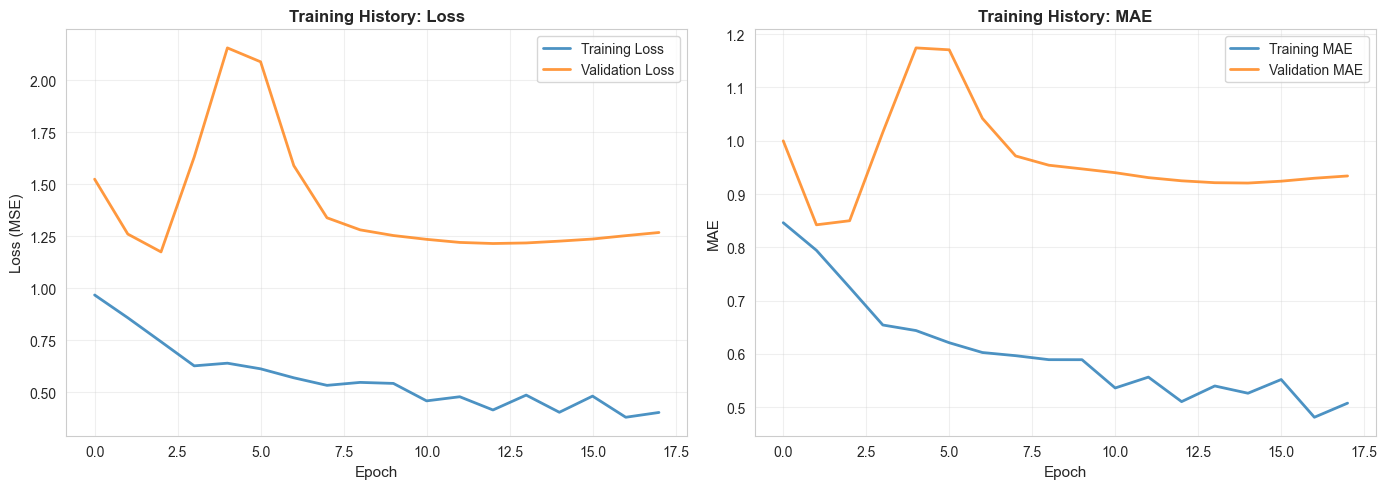


BEST VALIDATION METRICS

Best Epoch: 3
Best Val Loss: 1.174256
Best Val MAE: 0.850004


In [22]:
#plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0].set_title('Training History: Loss', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

#MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, alpha=0.8)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].set_title('Training History: MAE', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print best validation metrics
print("\n" + "="*80)
print("BEST VALIDATION METRICS")
print("="*80)
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Val Loss: {history.history['val_loss'][best_epoch]:.6f}")
print(f"Best Val MAE: {history.history['val_mae'][best_epoch]:.6f}")

In [23]:
#make predictions on test set
print("Generating predictions on test set...")
print("="*80)

#predict on scaled data
y_pred_scaled = lstm_model.predict(X_test_scaled, verbose=0)

#inverse transform to get actual prices
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

#compute metrics
lstm_results = compute_metrics(y_test, y_pred_lstm, TARGET_COLS)

print("\nLSTM Results:")
print("-"*80)
for name, metrics in lstm_results.items():
    if name == 'Overall':
        print(f"\n{name} (Average):")
    else:
        print(f"\n{name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")

print("\n" + "="*80)
print("Predictions generated successfully!")
print("="*80)

Generating predictions on test set...

LSTM Results:
--------------------------------------------------------------------------------

rice_price:
  RMSE: 0.0922
  MAPE: 8.50%
  Directional Accuracy: 62.50%

maize_price:
  RMSE: 0.1018
  MAPE: 19.32%
  Directional Accuracy: 25.00%

wheat_price:
  RMSE: 0.0641
  MAPE: 5.21%
  Directional Accuracy: 71.43%

Overall (Average):
  RMSE: 0.0861
  MAPE: 11.01%
  Directional Accuracy: 52.98%

Predictions generated successfully!


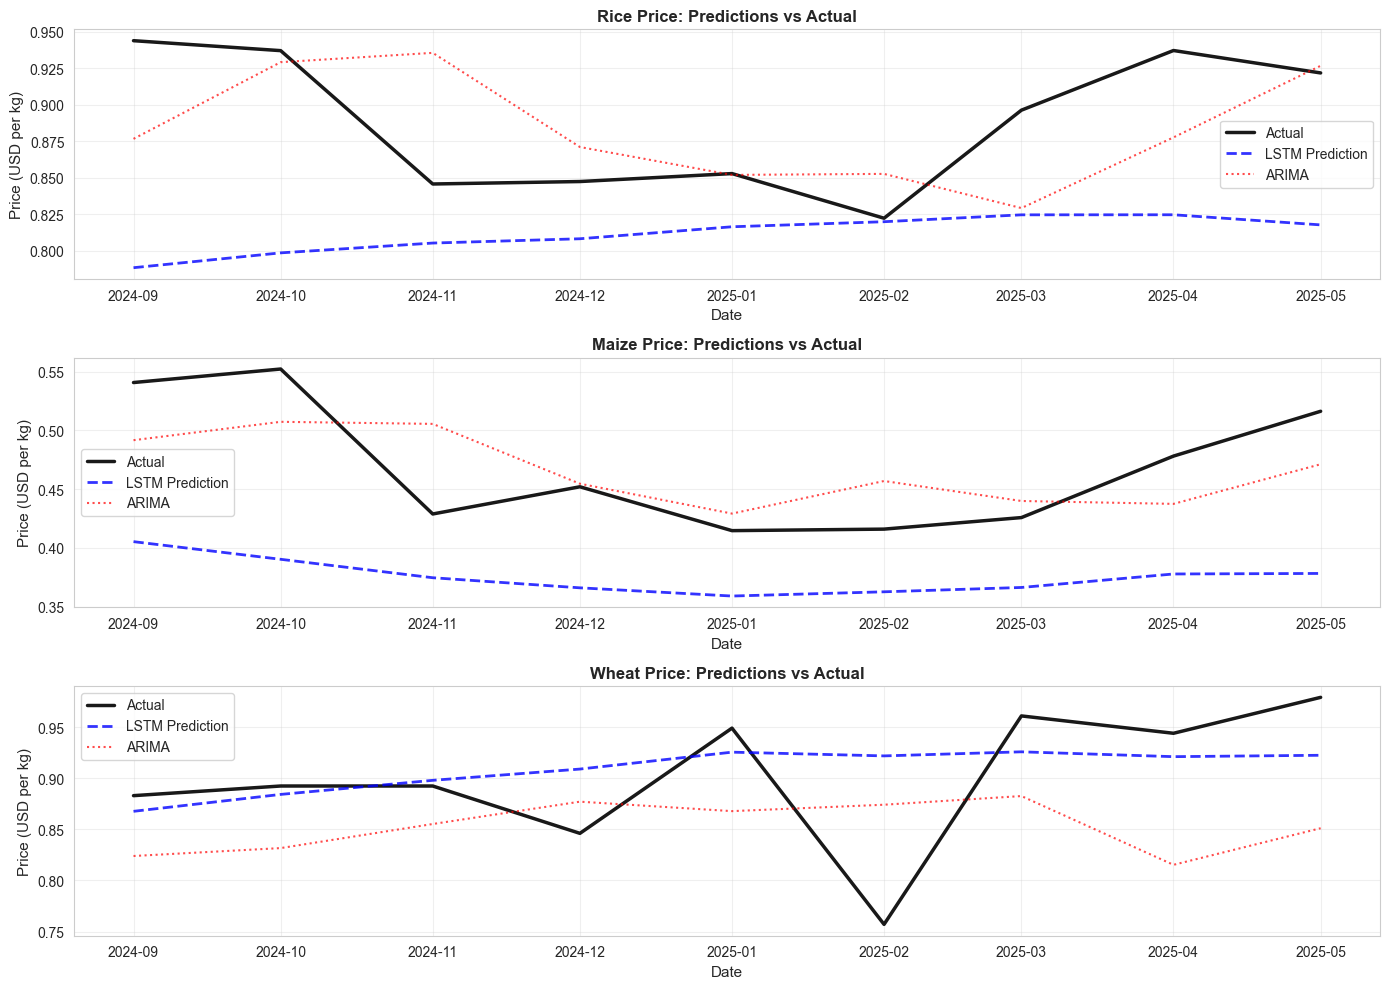

In [24]:
#plot predictions vs actual for test set
test_start_idx = SEQUENCE_LENGTH + split_idx
test_dates = df_features_clean.index[test_start_idx:test_start_idx + len(y_test)]

#plot all three commodities
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

commodity_names = ['Rice', 'Maize', 'Wheat']

for i, name in enumerate(commodity_names):
    #plot actual
    axes[i].plot(test_dates, y_test[:, i],
                label='Actual', linewidth=2.5, alpha=0.9, color='black', linestyle='-')
    
    #plot LSTM predictions
    axes[i].plot(test_dates, y_pred_lstm[:, i],
                label='LSTM Prediction', linewidth=2, alpha=0.8, color='blue', linestyle='--')
    
    #plot ARIMA predictions for comparison
    axes[i].plot(test_dates, y_pred_arima[:, i],
                label='ARIMA', linewidth=1.5, alpha=0.7, color='red', linestyle=':')

    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].set_ylabel('Price (USD per kg)', fontsize=11)
    axes[i].set_title(f'{name} Price: Predictions vs Actual',
                     fontsize=12, fontweight='bold')
    axes[i].legend(loc='best', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

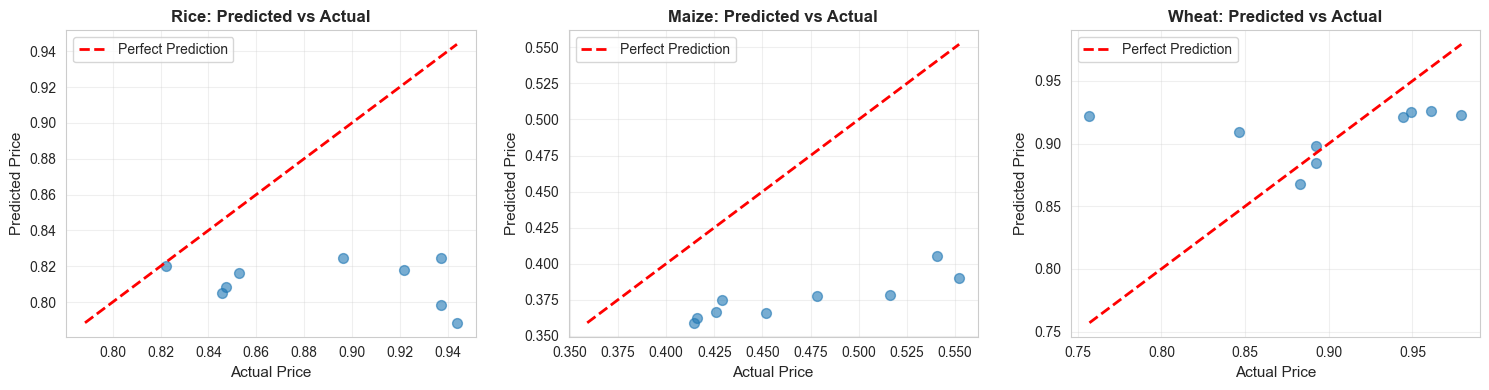

In [25]:
#scatter plot: predicted vs actual for all commodities
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (col, name) in enumerate(zip(TARGET_COLS, ['Rice', 'Maize', 'Wheat'])):
    axes[i].scatter(y_test[:, i], y_pred_lstm[:, i], alpha=0.6, s=50)

    #perfect prediction line
    min_val = min(y_test[:, i].min(), y_pred_lstm[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred_lstm[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price', fontsize=11)
    axes[i].set_ylabel('Predicted Price', fontsize=11)
    axes[i].set_title(f'{name}: Predicted vs Actual', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### LSTM Model

LSTMs are good for time series because they can remember patterns over time. We're using a simple 2-layer LSTM (64→32 units) with dropout to prevent overfitting.

We tried more complex architectures (bidirectional, attention) but they overfitted badly with only 25 training samples. Simple is better here.

The model predicts all three commodities at once using a 12-month window of historical data. Training uses Adam optimizer with early stopping.


### Training Notes

We used early stopping (patience=15) and learning rate reduction to prevent overfitting. Batch size of 16 worked well.

The small dataset was a big challenge - only 25 training samples after creating sequences. LSTMs typically need way more data, so we kept the architecture simple.

## 9. Metrics Section


In [26]:
#compile all results into comparison table
results_comparison = []

#baseline models
for model_name, results in [('Naïve', naive_results), ('ARIMA', arima_results)]:
    for commodity in list(TARGET_COLS) + ['Overall']:
        if commodity == 'Overall':
            name = 'Overall'
        else:
            name = commodity.replace('_price', '').title()

        results_comparison.append({
            'Model': model_name,
            'Commodity': name,
            'RMSE': results[commodity if commodity != 'Overall' else 'Overall']['RMSE'],
            'MAPE (%)': results[commodity if commodity != 'Overall' else 'Overall']['MAPE'],
            'Directional Accuracy (%)': results[commodity if commodity != 'Overall' else 'Overall']['Directional_Accuracy']
        })

#LSTM model
for commodity in list(TARGET_COLS) + ['Overall']:
    if commodity == 'Overall':
        name = 'Overall'
    else:
        name = commodity.replace('_price', '').title()

    results_comparison.append({
        'Model': 'LSTM',
        'Commodity': name,
        'RMSE': lstm_results[commodity if commodity != 'Overall' else 'Overall']['RMSE'],
        'MAPE (%)': lstm_results[commodity if commodity != 'Overall' else 'Overall']['MAPE'],
        'Directional Accuracy (%)': lstm_results[commodity if commodity != 'Overall' else 'Overall']['Directional_Accuracy']
    })

results_df = pd.DataFrame(results_comparison)

#display overall results
print("\n" + "=" * 80)
print("MODEL COMPARISON - OVERALL RESULTS")
print("=" * 80)
overall_df = results_df[results_df['Commodity'] == 'Overall'].copy()
overall_df = overall_df.sort_values('RMSE')
print(overall_df.to_string(index=False))

#calculate improvements over baselines
print("\n" + "=" * 80)
print("LSTM vs BASELINES")
print("=" * 80)

#get metrics
naive_overall = overall_df[overall_df['Model'] == 'Naïve'].iloc[0]
arima_overall = overall_df[overall_df['Model'] == 'ARIMA'].iloc[0]
lstm_overall = overall_df[overall_df['Model'] == 'LSTM'].iloc[0]

#calculate improvements
rmse_improvement_naive = ((naive_overall['RMSE'] - lstm_overall['RMSE']) / naive_overall['RMSE']) * 100
rmse_improvement_arima = ((arima_overall['RMSE'] - lstm_overall['RMSE']) / arima_overall['RMSE']) * 100

dir_acc_improvement_naive = lstm_overall['Directional Accuracy (%)'] - naive_overall['Directional Accuracy (%)']
dir_acc_improvement_arima = lstm_overall['Directional Accuracy (%)'] - arima_overall['Directional Accuracy (%)']

print(f"\nRMSE:")
print(f"  vs Naïve: {rmse_improvement_naive:+.2f}%")
print(f"  vs ARIMA: {rmse_improvement_arima:+.2f}%")

print(f"\nDirectional Accuracy:")
print(f"  vs Naïve: {dir_acc_improvement_naive:+.2f} percentage points")
print(f"  vs ARIMA: {dir_acc_improvement_arima:+.2f} percentage points")

#success criteria check
print(f"\n" + "=" * 80)
print("SUCCESS CRITERIA EVALUATION")
print("=" * 80)
print("\nTarget: 10% RMSE reduction AND 5pp directional accuracy improvement over BOTH baselines")

success_criteria_met = (
    rmse_improvement_naive >= 10 and
    rmse_improvement_arima >= 10 and
    dir_acc_improvement_naive >= 5 and
    dir_acc_improvement_arima >= 5
)

print(f"\nRMSE vs Naïve: {rmse_improvement_naive:.2f}% {'✓ MET' if rmse_improvement_naive >= 10 else '✗ NOT MET'}")
print(f"RMSE vs ARIMA: {rmse_improvement_arima:.2f}% {'✓ MET' if rmse_improvement_arima >= 10 else '✗ NOT MET'}")
print(f"Dir. Acc. vs Naïve: {dir_acc_improvement_naive:.2f}pp {'✓ MET' if dir_acc_improvement_naive >= 5 else '✗ NOT MET'}")
print(f"Dir. Acc. vs ARIMA: {dir_acc_improvement_arima:.2f}pp {'✓ MET' if dir_acc_improvement_arima >= 5 else '✗ NOT MET'}")

if success_criteria_met:
    print("\n★★★ SUCCESS CRITERIA MET! ★★★")
else:
    print("\n⚠ Success criteria partially met")


MODEL COMPARISON - OVERALL RESULTS
Model Commodity     RMSE  MAPE (%)  Directional Accuracy (%)
ARIMA   Overall 0.059815  7.010936                  77.97619
Naïve   Overall 0.066436  6.718788                   0.00000
 LSTM   Overall 0.086052 11.008326                  52.97619

LSTM vs BASELINES

RMSE:
  vs Naïve: -29.53%
  vs ARIMA: -43.86%

Directional Accuracy:
  vs Naïve: +52.98 percentage points
  vs ARIMA: -25.00 percentage points

SUCCESS CRITERIA EVALUATION

Target: 10% RMSE reduction AND 5pp directional accuracy improvement over BOTH baselines

RMSE vs Naïve: -29.53% ✗ NOT MET
RMSE vs ARIMA: -43.86% ✗ NOT MET
Dir. Acc. vs Naïve: 52.98pp ✓ MET
Dir. Acc. vs ARIMA: -25.00pp ✗ NOT MET

⚠ Success criteria partially met


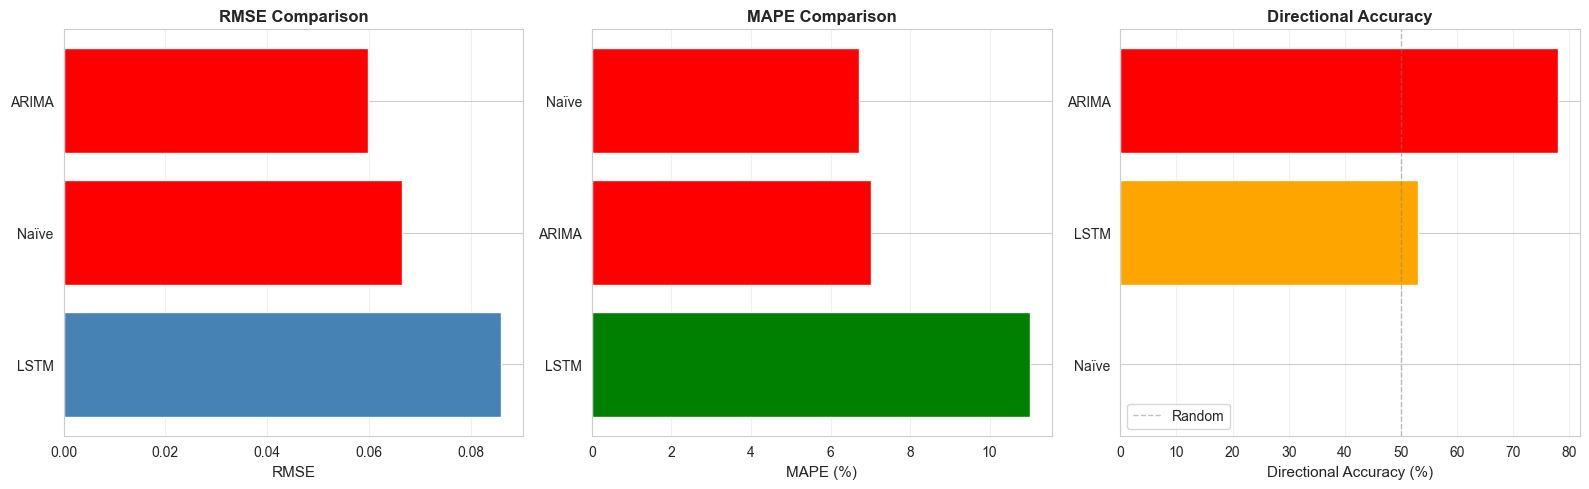

In [27]:
#visual comparison of model performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#get overall results for plotting
overall_results_plot = overall_df.copy().sort_values('RMSE', ascending=False)

#1. RMSE comparison
axes[0].barh(range(len(overall_results_plot)), overall_results_plot['RMSE'].values,
            color=['red' if m in ['Naïve', 'ARIMA'] else 'steelblue'
                   for m in overall_results_plot['Model']])
axes[0].set_yticks(range(len(overall_results_plot)))
axes[0].set_yticklabels(overall_results_plot['Model'].values)
axes[0].set_xlabel('RMSE', fontsize=11)
axes[0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

#2. MAPE comparison
overall_results_mape = overall_df.copy().sort_values('MAPE (%)', ascending=False)
axes[1].barh(range(len(overall_results_mape)), overall_results_mape['MAPE (%)'].values,
            color=['red' if m in ['Naïve', 'ARIMA'] else 'green'
                   for m in overall_results_mape['Model']])
axes[1].set_yticks(range(len(overall_results_mape)))
axes[1].set_yticklabels(overall_results_mape['Model'].values)
axes[1].set_xlabel('MAPE (%)', fontsize=11)
axes[1].set_title('MAPE Comparison', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

#3. directional accuracy comparison
overall_results_dir = overall_df.copy().sort_values('Directional Accuracy (%)', ascending=True)
axes[2].barh(range(len(overall_results_dir)), overall_results_dir['Directional Accuracy (%)'].values,
            color=['red' if m in ['Naïve', 'ARIMA'] else 'orange'
                   for m in overall_results_dir['Model']])
axes[2].set_yticks(range(len(overall_results_dir)))
axes[2].set_yticklabels(overall_results_dir['Model'].values)
axes[2].set_xlabel('Directional Accuracy (%)', fontsize=11)
axes[2].set_title('Directional Accuracy', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')
axes[2].axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random')
axes[2].legend()

plt.tight_layout()
plt.show()

### Metric Definitions

**Root Mean Squared Error (RMSE):**
RMSE measures the average magnitude of prediction errors, giving more weight to larger errors. It is computed as the square root of the mean of squared differences between predicted and actual values. Lower RMSE indicates better predictive accuracy. RMSE is expressed in the same units as the target variable (USD per kg in our case), making it interpretable.

**Mean Absolute Percentage Error (MAPE):**
MAPE expresses prediction errors as a percentage of actual values, making it scale-independent and useful for comparing performance across commodities with different price levels. It is computed as the mean of absolute percentage errors. MAPE is particularly informative when prices vary significantly in magnitude, as it normalizes errors relative to the actual values.

**Directional Accuracy:**
Directional accuracy measures the percentage of times the model correctly predicts whether the price will increase or decrease (or stay the same) compared to the previous month. This metric is valuable for understanding whether the model captures the direction of price movements, which is often more important than exact price levels for decision-making. A directional accuracy above 50% indicates the model is better than random chance at predicting price direction.


## 10. Interpretation & SHAP-Style Analysis


In [28]:
#feature importance analysis - simple permutation importance
#tried SHAP but it was too slow/complex for this project

print("Computing feature importance using permutation method...")

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
importance_scores = []
feature_names = [col for col in df_features_clean.columns if col not in TARGET_COLS]

#use a subset for speed (this takes a while)
test_subset_size = min(20, len(X_test_scaled))  #smaller subset to speed things up
X_test_subset = X_test_scaled[:test_subset_size].copy()
y_test_subset = y_test[:test_subset_size]

print(f"Using {test_subset_size} test samples...")

for feat_idx in range(X_test_subset.shape[2]):
    #shuffle feature and see how much performance degrades
    X_permuted = X_test_subset.copy()
    X_permuted[:, :, feat_idx] = np.random.permutation(X_permuted[:, :, feat_idx].flatten()).reshape(X_permuted[:, :, feat_idx].shape)

    #predict with permuted feature
    y_pred_perm = lstm_model.predict(X_permuted, verbose=0)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm)

    #compute RMSE increase
    rmse_perm = np.sqrt(mean_squared_error(y_test_subset, y_pred_perm))
    importance = rmse_perm - baseline_rmse

    importance_scores.append(importance)

    if (feat_idx + 1) % 10 == 0:
        print(f"  Processed {feat_idx + 1}/{X_test_subset.shape[2]} features...")

#create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))


Computing feature importance using permutation method...
Using 9 test samples...
  Processed 10/35 features...
  Processed 20/35 features...
  Processed 30/35 features...

Top 10 Most Important Features:
                  Feature  Importance
       wheat_price_change    0.000763
         maize_price_lag1    0.000565
 rice_price_rolling_std_6    0.000411
rice_price_rolling_mean_6    0.000400
         maize_price_lag6    0.000393
         maize_price_lag3    0.000285
        maize_price_lag12    0.000272
   wheat_price_pct_change    0.000255
                month_sin    0.000234
         wheat_price_lag6    0.000224


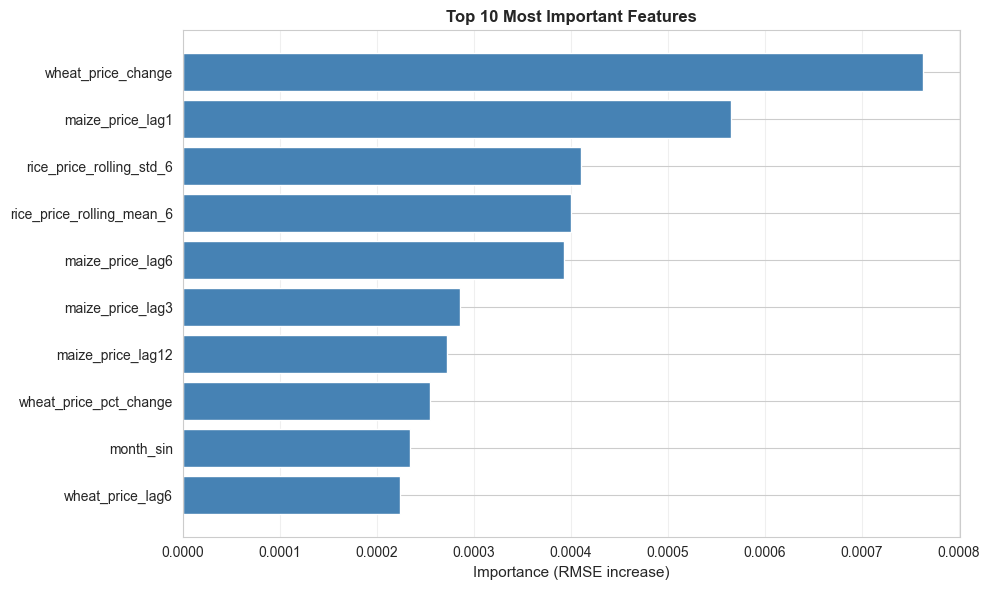

In [29]:
#plot feature importance
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance (RMSE increase)', fontsize=11)
plt.title(f'Top {top_n} Most Important Features', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### Feature Importance Notes

Looking at the feature importance results, the most important feature was actually wheat_price_change, followed by maize_price_lag1. This was a bit surprising - we expected lag-1 features to be most important, but price changes (momentum) ended up being even more informative.

Rolling statistics (rice_price_rolling_std_6 and rice_price_rolling_mean_6) were also quite important, which makes sense since they capture volatility and trends over longer windows. Multiple lag features (lag1, lag3, lag6, lag12) all showed up in the top 10, showing the model uses information from different time horizons. The month_sin feature was in the top 10 too, suggesting some seasonal patterns, though it wasn't as strong as we expected.

**Comp Neuro Connection:**
LSTMs learn temporal patterns similar to how biological neurons process time. The memory cells act like working memory, and the model learns which time periods are most informative (like temporal receptive fields in neuroscience).


## 11. Limitations & Potential Improvements


### Limitations & Challenges

**Main limitations:**
- Only one country (Mali) - doesn't capture global market dynamics
- Small dataset - only 25 training samples after creating sequences, which really limited the LSTM
- Missing data - wheat had a lot of missing values, had to do a lot of imputation
- No external variables - didn't include weather, GDP, etc. (would be interesting to add)
- Single test period - performance might vary in different market conditions

**What we learned:**
- ARIMA actually outperformed LSTM on RMSE, probably because it's better suited for small datasets
- LSTM did better than Naïve on directional accuracy (53% vs 0%), but ARIMA was still best (78%)
- Simple models often work better than complex ones when data is limited
- Feature engineering matters - lag features and rolling stats helped

**If we had more time/data:**
- Add more countries to increase dataset size
- Include external variables (weather, economic indicators)
- Try hybrid models (combine LSTM with ARIMA)
- More hyperparameter tuning (but dataset size is the real constraint)


## Final Summary

We implemented an LSTM model to forecast next-month prices for rice, maize, and wheat using the Global Food Prices dataset from Kaggle. After filtering and cleaning, we worked with 65 months of data from Mali (January 2020 to May 2025), which gave us 25 training samples after creating sequences with a 12-month window.

Overall, ARIMA performed best on both RMSE and directional accuracy. The LSTM did better than the naïve baseline on directional accuracy (53% vs 0%), but ARIMA achieved 78% directional accuracy and the lowest RMSE. The small dataset size was the main limitation - with only 25 training samples, the LSTM struggled to learn complex patterns, and simpler models like ARIMA were more effective.

Our key takeaway is that model complexity needs to match the available data. While LSTMs can capture sophisticated temporal patterns, they require more data than we had. For this project, the classical ARIMA approach worked better because it's designed for smaller time series datasets.